### prepare modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import QUANTAXIS as QA
import talib as ta
import datetime, time
# import pandas_datareader.data as web

from utils import get_data, get_code_list_by_sector
from utils import select_code, position_side
from utils import single_pair_trading, batch_pair_trading
from utils import calc_pair_trading

try:
    from tqdm import tqdm_notebook
except:
    pass

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

### prepare data

In [3]:
code_list_by_sector = pd.read_excel('data/etf_pair_code.xlsx', dtype={'symbol':str})
sector_list = code_list_by_sector.sector.unique().tolist()
etf_list = code_list_by_sector.etf_symbol.unique().tolist()
region_list = code_list_by_sector.region.unique().tolist()

us_data = get_data('data/us_data.csv')
hk_data = get_data('data/hk_data.csv')

In [5]:
hk_data.head()

,,high,low,open,close,volume,Adj Close
date,code,,,,,,
2015-06-29,3396.hk,43.549999,42.849998,43.150002,42.950001,62651090.0,41.258984
2015-06-30,3396.hk,43.450001,43.000000,43.000000,43.349998,8230600.0,41.643234
2015-07-02,3396.hk,43.950001,42.950001,43.349998,43.849998,7664889.0,42.123547
2015-07-03,3396.hk,43.900002,42.950001,43.849998,43.000000,5044400.0,41.307014
2015-07-06,3396.hk,43.500000,40.900002,43.049999,42.549999,29058194.0,40.874729


1. 遍历得到ratio的图，还包括ratio的上下轨，rsi等等
2. 这个还是写到表里面去吧，免得麻烦
3. 但也不行，因为这个是板块的
4. 总之先把单个的先做了

In [14]:
hk_data.index.get_level_values(1).unique().tolist()

['3396.hk',
 '3969.hk',
 '0968.hk',
 '1347.hk',
 '6088.hk',
 '6869.hk',
 '1357.hk',
 '1089.hk',
 '0327.hk',
 '1980.hk',
 '0877.hk',
 '0434.hk',
 '0799.hk',
 '1337.hk']

In [4]:
result = single_pair_trading(hk_data, '3396.hk', '3969.hk')

In [5]:
result['long_return']

-0.0006266263037303483

In [6]:
result['long_short_return']

-0.0008917708617966346

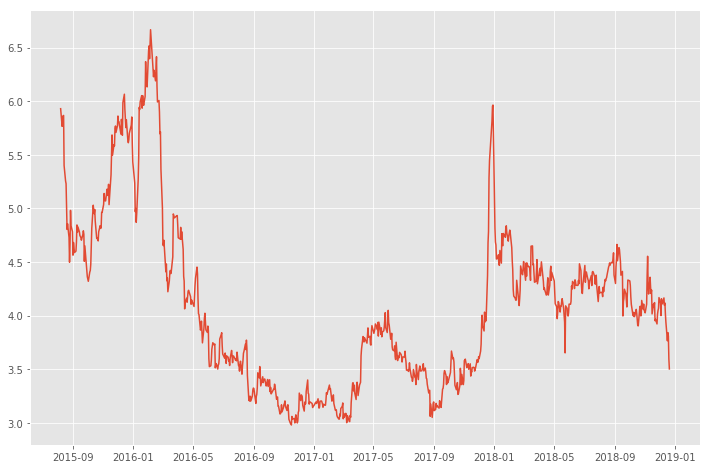

In [7]:
plt.plot(result['ratio'].index, result['ratio'].values);

1. 先选定sector
2. 再取出sector里的code
3. 

In [5]:
hk_data_code_list = hk_data.index.get_level_values(1).unique().tolist()

In [40]:
df_ratio = pd.DataFrame()
df_long_asset = pd.DataFrame()
lens = len(hk_data_code_list)
long_return_mat = np.zeros((lens,lens))
long_short_return_mat = np.zeros((lens,lens))
for i in range(lens):
    for j in range(i+1, lens):
        code1 = hk_data_code_list[i]
        code2 = hk_data_code_list[j]
        temp_result = single_pair_trading(hk_data, code1, code2)
        temp_result['ratio'].name = "%s-%s" % (code1,code2)
        temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)
        
        df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
        df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                 axis=1)
        long_return_mat[i, j] = temp_result['long_return']
        long_short_return_mat[i, j] = temp_result['long_short_return']
        
df_long_return = pd.DataFrame(long_return_mat)
df_long_return.index = hk_data_code_list
df_long_return.columns = hk_data_code_list
df_long_return

df_long_short_return = pd.DataFrame(long_short_return_mat)
df_long_short_return.index = hk_data_code_list
df_long_short_return.columns = hk_data_code_list
df_long_short_return

In [53]:
temp_result.keys()

dict_keys(['ratio', 'real_signal', 'long_asset_series', 'long_return', 'long_short_return'])

In [59]:
def batch_pair_trading(code_list, data):

    df_ratio = pd.DataFrame()
    df_long_asset = pd.DataFrame()
    lens = len(code_list)
    long_return_mat = np.zeros((lens,lens))
    long_short_return_mat = np.zeros((lens,lens))
    for i in range(lens):
        for j in range(i+1, lens):
            code1 = code_list[i]
            code2 = code_list[j]
            temp_result = single_pair_trading(data, code1, code2)
            temp_result['ratio'].name = "%s-%s" % (code1,code2)
            temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)

            df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
            df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                     axis=1)
            long_return_mat[i, j] = temp_result['long_return']
            long_short_return_mat[i, j] = temp_result['long_short_return']

    df_long_return = pd.DataFrame(long_return_mat)
    df_long_return.index = code_list
    df_long_return.columns = code_list
    df_long_return

    df_long_short_return = pd.DataFrame(long_short_return_mat)
    df_long_short_return.index = code_list
    df_long_short_return.columns = code_list
    df_long_short_return
    
    result = {}
    
    result['ratio'] = df_ratio
    result['long_asset'] = df_long_asset
    result['long_return'] = df_long_return
    result['long_short_return'] = df_long_short_return
    
    return result

In [60]:
def batch_pair_trading(code_list, data):

    df_ratio = pd.DataFrame()
    df_long_asset = pd.DataFrame()
    lens = len(code_list)
    long_return_mat = np.zeros((lens,lens))
    long_short_return_mat = np.zeros((lens,lens))
    for i in tqdm_notebook(range(lens)):
        for j in tqdm_notebook(range(i+1, lens)):
            code1 = code_list[i]
            code2 = code_list[j]
            temp_result = single_pair_trading(data, code1, code2)
            temp_result['ratio'].name = "%s-%s" % (code1,code2)
            temp_result['long_asset_series'].name = "%s-%s" % (code1,code2)

            df_ratio = pd.concat([df_ratio, temp_result['ratio']], axis=1)
            df_long_asset = pd.concat([df_long_asset, temp_result['long_asset_series']],
                                     axis=1)
            long_return_mat[i, j] = temp_result['long_return']
            long_short_return_mat[i, j] = temp_result['long_short_return']

    df_long_return = pd.DataFrame(long_return_mat)
    df_long_return.index = code_list
    df_long_return.columns = code_list
    df_long_return

    df_long_short_return = pd.DataFrame(long_short_return_mat)
    df_long_short_return.index = code_list
    df_long_short_return.columns = code_list
    df_long_short_return
    
    result = {}
    
    result['ratio'] = df_ratio
    result['long_asset'] = df_long_asset
    result['long_return'] = df_long_return
    result['long_short_return'] = df_long_short_return
    
    return result

In [61]:
result = batch_pair_trading(hk_data_code_list, hk_data)

In [56]:
result['long_short_return'].sum().sum()

0.075217086119152649

In [51]:
df_long_short_return.sum().sum()

0.075217086119152649

In [52]:
df_long_return.sum().sum()

0.023874766979341568

In [37]:
temp_result['long_asset_series'].name

In [34]:
df_ratio.tail()

,3396.hk-3969.hk,3396.hk-0968.hk,3396.hk-1347.hk,3396.hk-6088.hk,3396.hk-6869.hk,3396.hk-1357.hk,3396.hk-1089.hk,3396.hk-0327.hk,3396.hk-1980.hk,3396.hk-0877.hk,...,1980.hk-0877.hk,1980.hk-0434.hk,1980.hk-0799.hk,1980.hk-1337.hk,0877.hk-0434.hk,0877.hk-0799.hk,0877.hk-1337.hk,0434.hk-0799.hk,0434.hk-1337.hk,0799.hk-1337.hk
date,,,,,,,,,,,,,,,,,,,,,
2018-12-17,3.765217,7.569930,1.398579,6.482036,0.957965,8.909465,10.879397,6.386430,6.348973,6.030641,...,0.949861,2.418440,0.332359,3.072072,2.546099,0.349903,3.234234,0.137427,1.270270,9.243243
2018-12-18,3.841354,7.751798,1.423382,6.490964,0.981777,9.577777,11.051281,6.530303,6.630769,5.986111,...,0.902778,2.355072,0.314313,3.037383,2.608696,0.348162,3.364486,0.133462,1.289720,9.663551
2018-12-19,3.809107,7.996323,1.410506,6.304348,1.025943,9.497817,11.211340,7.250000,6.531532,6.286127,...,0.962428,2.448529,0.324561,3.112149,2.544118,0.337232,3.233645,0.132554,1.271028,9.588785
2018-12-20,3.595890,7.692308,1.413190,6.086956,1.000000,9.545454,10.552764,7.394366,6.583072,5.982906,...,0.908832,2.362963,0.311523,3.009434,2.600000,0.342773,3.311321,0.131836,1.273585,9.660378
2018-12-21,3.502664,7.093525,1.371349,5.732558,0.961951,9.390476,10.378947,6.753424,6.444444,5.782991,...,0.897361,2.300752,0.295367,2.914286,2.563910,0.329151,3.247619,0.128378,1.266667,9.866667


In [32]:
pd.DataFrame(long_return_mat)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


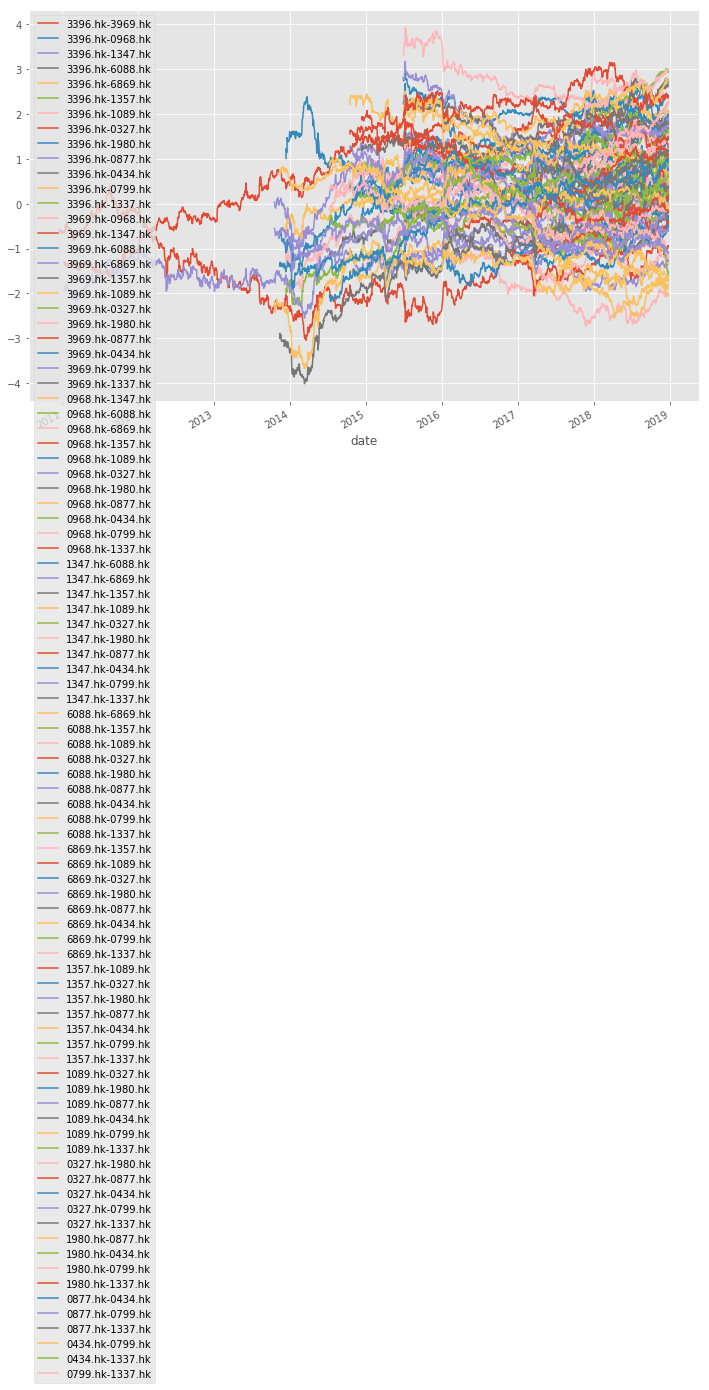

In [7]:
df_ratio.applymap(lambda x: np.log(x)).plot();

### visualization

- input : sector or etf code
- output : 
    - ratio plotting
    - long return matrix
    - long short return matrix
    
- input : two code
- output :
    - ratio plotting with upper & lower bond
    - long return & long short return

sector or etf symbol list

In [9]:
code_list_by_sector.head()

,symbol,region,etf_symbol,sector
0,MSFT,US Equity,XLK,Hardware
1,AAPL,US Equity,XLK,Hardware
2,V,US Equity,XLK,Hardware
3,INTC,US Equity,XLK,Hardware
4,CSCO,US Equity,XLK,Hardware


In [15]:
code_list_by_sector.etf_symbol.value_counts().index

Index(['IBB', 'VDE', 'PNQI', 'CQQQ', 'GAMR', 'XLK', 'XLY', 'XLV', 'HACK',
       'ITA', 'XLP', 'PSJ', 'SOXX', 'SKYY', 'IAI', 'SMH', 'XLB'],
      dtype='object')

In [11]:
code_list_by_sector.sector.value_counts()

Biotech/ Pharma              191
Energy                       143
Internet                      95
China Internet                78
Online Gaming                 72
Hardware                      68
Consumer                      66
Medical                       63
Network/Security              53
Health Care Services          36
Defense                       32
Software/ Cloud Computing     31
ePayment                      30
Cloud Computing               29
Financials                    27
Semiconductor                 25
Others                        24
Name: sector, dtype: int64

In [49]:
type(code_list_by_sector.query('sector == "%s"' % 'Biotech/ Pharma').symbol.tolist()) == list

True

test

In [ ]:
us_data

In [3]:
result = calc_pair_trading('SMH')

In [4]:
result['ratio'].head()

,INTC-TSM,INTC-AVGO,INTC-ASML,INTC-TXN,INTC-ADI,INTC-NVDA,INTC-LRCX,INTC-AMAT,INTC-NXPI,INTC-MU,...,MRVL-ON,MRVL-QRVO,MRVL-TER,MRVL-OLED,ON-QRVO,ON-TER,ON-OLED,QRVO-TER,QRVO-OLED,TER-OLED
date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,1.812475,0.973339,0.614919,0.738264,0.618432,0.888731,0.420008,1.328693,NaN,1.453559,...,2.073393,NaN,1.791771,1.484311,NaN,0.864173,0.715885,NaN,NaN,0.828404
2010-01-04,1.832693,0.966132,0.619037,0.757088,0.631185,0.918990,0.422668,1.325720,NaN,1.447995,...,2.089527,NaN,1.777842,1.464067,NaN,0.850835,0.700669,NaN,NaN,0.823508
2010-01-05,1.839760,0.958554,0.613958,0.761114,0.631880,0.905330,0.425345,1.335357,NaN,1.405839,...,2.148649,NaN,1.805069,1.400392,NaN,0.840095,0.651755,NaN,NaN,0.775811
2010-01-06,1.839972,0.947856,0.606344,0.764176,0.630958,0.896558,0.425854,1.333698,NaN,1.394880,...,2.140908,NaN,1.837780,1.348998,NaN,0.858412,0.630105,NaN,NaN,0.734037
2010-01-07,1.884608,0.944661,0.617686,0.754477,0.629880,0.905687,0.422509,1.335015,NaN,1.429895,...,2.093747,NaN,1.785450,1.319662,NaN,0.852753,0.630287,NaN,NaN,0.739120


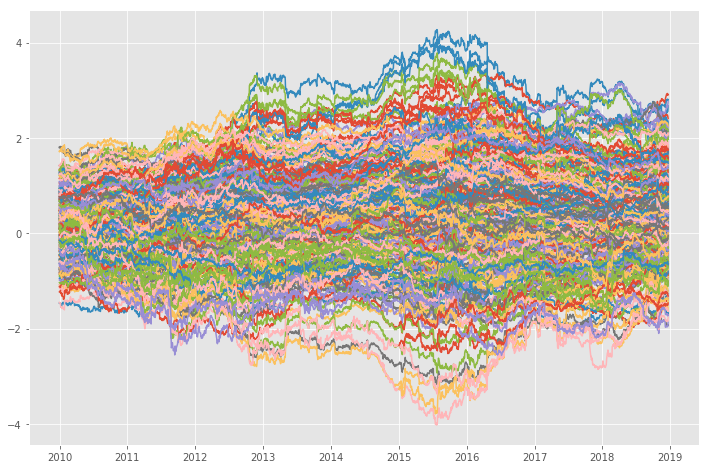

In [7]:
plt.plot(result['ratio'].index, result['ratio'].apply(lambda x : np.log(x)).values);

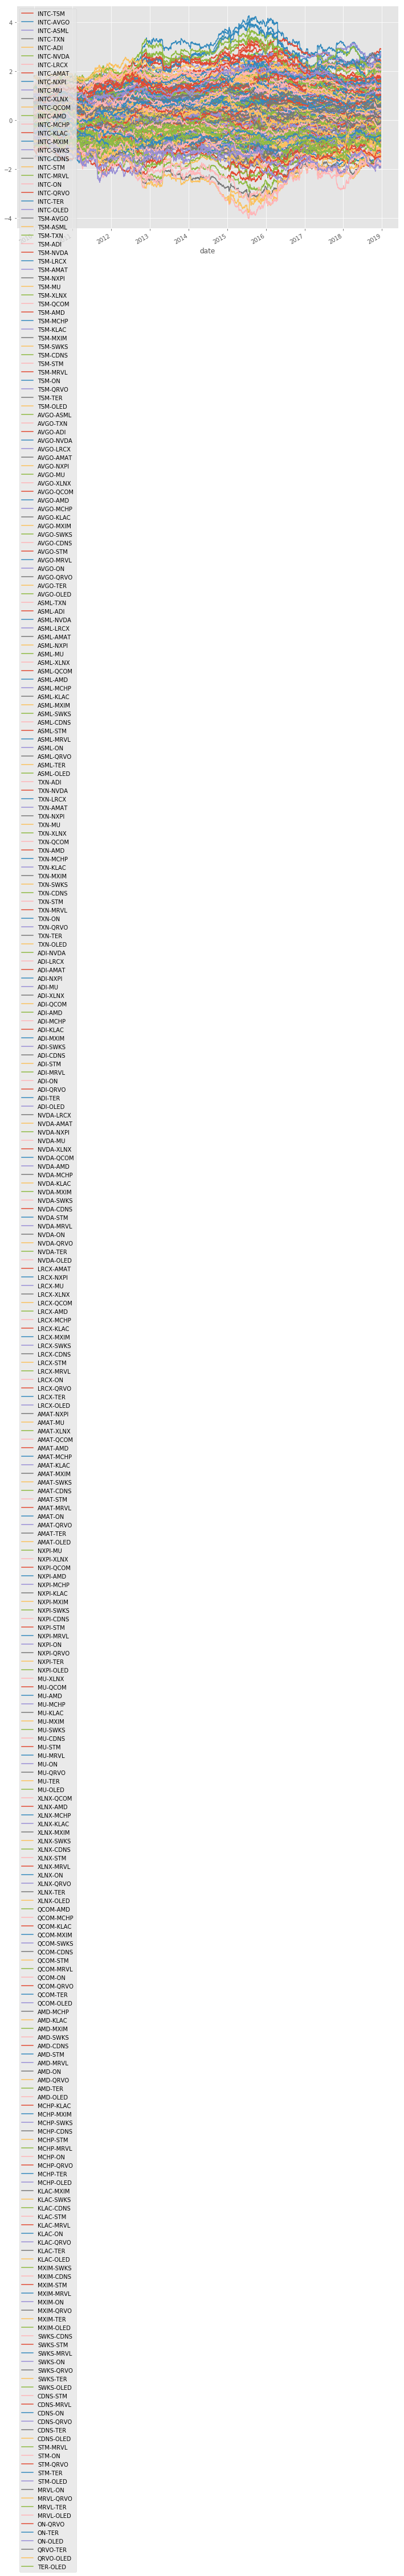

In [8]:
result['ratio'].apply(lambda x : np.log(x)).plot();

In [9]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling')

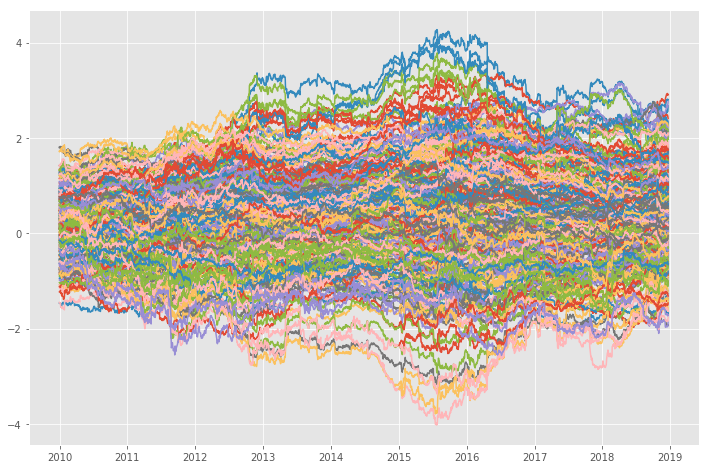

In [10]:
plt.plot(rolling_mean_result['ratio'].index, 
         rolling_mean_result['ratio'].apply(lambda x : np.log(x)).values);

In [11]:
result['long_return'].sum().sum()

0.22396310741538117

In [ ]:
result['long_short_return'].sum().sum()

rolling mean, period : 14

In [13]:
rolling_mean_result['long_return'].sum().sum()

0.2027546976497436

In [14]:
rolling_mean_result['long_short_return'].sum().sum()

-0.06371614485490215

rolling mean, period : 20

In [15]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling', period=20)

In [16]:
rolling_mean_result['long_return'].sum().sum()

0.21449473561696744

In [ ]:
rolling_mean_result['long_short_return'].sum().sum()

rolling mean, period : 60

In [18]:
rolling_mean_result = calc_pair_trading('SMH', method='rolling', period=60)

In [19]:
rolling_mean_result['long_return'].sum().sum()

0.2327909784437065

In [20]:
rolling_mean_result['long_short_return'].sum().sum()

-0.003643583266976275

find the best period

In [9]:
long_return_list = []
long_short_return_list = []
for i in tqdm_notebook(range(16,31)):
    temp_result = calc_pair_trading('SMH', method='rolling', period=int(i*10),
                                   show_bar=False)
    long_return_list.append(temp_result['long_return'].sum().sum())
    long_short_return_list.append(temp_result['long_short_return'].sum().sum())

In [7]:
long_list_1 = long_return_list.copy()

In [8]:
long_short_list_2 = long_short_return_list.copy()

In [10]:
long_list = long_list_1 + long_return_list
long_short_list = long_short_list_2 + long_short_return_list

In [16]:
long_list[16]

0.2512215653060894

In [14]:
long_short_list[:18]

[-0.08082805221665113,
 -0.040236068920454525,
 -0.023436694450809852,
 -0.018006567181953335,
 -0.011156518195466633,
 -0.003643583266976275,
 0.006725811765336594,
 0.011886893752143638,
 0.018125685821203476,
 0.022679899774843203,
 0.019670721804821954,
 0.02075669173389704,
 0.023777867207131598,
 0.03101776289899273,
 0.026802012435442533,
 0.030645696492245342,
 0.03321759045778951,
 0.025656002186714162]

In [18]:
170/244 *12

8.360655737704917

In [3]:
ewm_mean_result = calc_pair_trading('SMH', method='ewm', period=170, show_bar=True)

In [6]:
ewm_mean_result['long_asset']['INTC-TSM']

date
2009-12-31     NaN
2010-01-04     TSM
2010-01-05    INTC
2010-01-06    INTC
2010-01-07    INTC
2010-01-08    INTC
2010-01-11    INTC
2010-01-12    INTC
2010-01-13    INTC
2010-01-14    INTC
2010-01-15    INTC
2010-01-19    INTC
2010-01-20    INTC
2010-01-21    INTC
2010-01-22    INTC
2010-01-25    INTC
2010-01-26    INTC
2010-01-27    INTC
2010-01-28    INTC
2010-01-29    INTC
2010-02-01     TSM
2010-02-02    INTC
2010-02-03    INTC
2010-02-04    INTC
2010-02-05    INTC
2010-02-08    INTC
2010-02-09    INTC
2010-02-10    INTC
2010-02-11    INTC
2010-02-12    INTC
              ... 
2018-11-08    INTC
2018-11-09    INTC
2018-11-12    INTC
2018-11-13    INTC
2018-11-14    INTC
2018-11-15    INTC
2018-11-16    INTC
2018-11-19    INTC
2018-11-20    INTC
2018-11-21    INTC
2018-11-23    INTC
2018-11-26    INTC
2018-11-27    INTC
2018-11-28    INTC
2018-11-29    INTC
2018-11-30    INTC
2018-12-03    INTC
2018-12-04    INTC
2018-12-06    INTC
2018-12-07    INTC
2018-12-10    INTC
2018-12

In [4]:
ewm_mean_result['long_short_return'].sum().sum()

0.01583926106445173

In [7]:
ewm_mean_result['long_short_return'].sum().sum()

0.015839261064451726

In [5]:
ewm_mean_result['long_return'].sum().sum()

0.2425324006094205

In [8]:
ewm_mean_result['long_return'].sum().sum()

0.24253240060942058

In [28]:
from string import ascii_letters

In [31]:
save_name = ''.join(np.random.choice(list(ascii_letters), 8))

In [32]:
save_name

'noeLrTHv'

In [33]:
is_saving = True

In [34]:
result = ewm_mean_result.copy()

In [58]:
keys = result.keys()

In [61]:
for i in result.keys():
    print(i, type(i))

ratio <class 'str'>
long_asset <class 'str'>
long_return <class 'str'>
long_short_return <class 'str'>


In [36]:
ratio = result['ratio']
long_asset = result['long_asset']
long_return = result['long_return']
long_short_return = result['long_short_return']

In [ ]:
ratio.to_excel(writer, sheet_name='ratio')

In [56]:
save_name = 'SMH_data'
if save_name is None:
    save_name = ''.join(np.random.choice(list(ascii_letters), 8))
    
result_path = os.getcwd()+'/result'
if os.path.exists(result_path) is False:
    os.makedirs(result_path)

writer = pd.ExcelWriter('result/'+save_name+'.xlsx', datetime_format='YYYY-MM-DD')

result['ratio'].to_excel(writer, sheet_name='ratio')
result['long_asset'].to_excel(writer, sheet_name='long_asset')
result['long_return'].to_excel(writer, sheet_name='long_return')
result['long_short_return'].to_excel(writer, sheet_name='long_short_return')

writer.save()

In [65]:
def store_in_excel(result, is_saving, save_name):
    
    if save_name is None:
        save_name = ''.join(np.random.choice(list(ascii_letters), 8))
    
    result_path = os.getcwd()+'/result'
    if os.path.exists(result_path) is False:
        os.makedirs(result_path)
    
    writer = pd.ExcelWriter('result/'+save_name+'.xlsx', datetime_format='YYYY-MM-DD')
    keys = list(result.keys())
    
    if (is_saving is True) or (is_saving.lower() == 'all'):
        for i in result.keys():
            result[i].to_excel(writer, sheet_name=i)
    elif is_saving.lower() == 'ratio':
        result['ratio'].to_excel(writer, sheet_name='ratio')
    elif is_saving.lower() == 'long_asset':
        result['long_asset'].to_excel(writer, sheet_name='long_asset')
    elif is_saving.lower() == 'long_return':
        result['long_return'].to_excel(writer, sheet_name='long_return')
    elif is_saving.lower() == 'long_short_return':
        result['long_return'].to_excel(writer, sheet_name='long_short_return')
    else:
        for i in is_saving:
            result[keys[i]].to_excel(writer, sheet_name=keys[i])
            
    writer.save()

In [67]:
store_in_excel(result, 'raTio', 'ratio')

In [40]:
import os
os.getcwd()

'E:\\Python\\tensorflow\\strategy_research\\task_temp'

In [51]:
result_path = os.getcwd()+'/result'
if os.path.exists(result_path) is False:
    os.makedirs(result_path)

In [46]:
os.path.exists(result_path)

True

In [55]:
'all' is 'all'

True

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
result = calc_pair_trading('SMH', method='ewm', is_saving='ratio', save_name='ratio_data',
                  period=170, show_bar=True)


finish, see youhold on...


In [ ]:
result = calc_pair_trading('SMH', method='ewm', is_saving='true', save_name='ratio_data',
                  period=170, show_bar=True)

In [8]:
from utils import *

In [14]:
store_in_excel(result, '23', 'return')

finish, see you          


In [4]:
from time import sleep

In [7]:
print('123')
print('32100000', end='')
sleep(0.5)
print('\r123')

123
12300000


In [21]:
# from tqdm import trange
# from time import sleep
for i in trange(10, desc='1st loop', leave=False):
    for j in trange(5, desc='\r2nd loop', leave=False):
#         for k in trange(100, desc='3nd loop'):
        sleep(0.01)



1st loop:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]


2nd loop:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]


                                                                                                                       


2nd loop:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]


                                                                                                                       

1st loop:  20%|██████████████▌                                                          | 2/10 [00:00<00:00, 15.88it/s]


2nd loop:   0%|                                                                                 | 0/5 [00:00<?, ?it/s]


                                                                                                                       


2nd loop:   0%|           

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm


def myfunc(a):
    return a ** 2


N = 100
pbar = tqdm(total=N)
res = [None] * N  # result list of correct size

def wrapMyFunc(arg):
    return arg, myfunc(arg)

def update(i, ans):
    # note: input comes from async `wrapMyFunc`
    res[i] = ans  # put answer into correct index of result list
    pbar.update()

pool = Pool(2)
for i in range(N):
    pool.apply_async(wrapMyFunc, args=(i,), callback=update)
pool.close()
pool.join()
pbar.close()



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]